In [1]:
from beam_solver.data import DATA_PATH
import catdata as cd
import beamsolve as bs
import beam_utils as bt
import nose.tools as nt
import numpy as np
import aipy
import os
import copy
import pylab
from collections import OrderedDict
import time
import linsolve

In [2]:
def recenter(a, c):
    """Slide the (0,0) point of matrix a to a new location tuple c.  This is
    useful for making an image centered on your screen after performing an
    inverse fft of uv data."""
    s = a.shape
    c = (c[0] % s[0], c[1] % s[1])
    if np.ma.isMA(a):
        a1 = np.ma.concatenate([a[c[0]:], a[:c[0]]], axis=0)
        a2 = np.ma.concatenate([a1[:,c[1]:], a1[:,:c[1]]], axis=1)
    else:
        a1 = np.concatenate([a[c[0]:], a[:c[0]]], axis=0)
        a2 = np.concatenate([a1[:,c[1]:], a1[:,:c[1]]], axis=1)
    return a2

def get_LM(dim, center=(0,0), res=1):
        """Get the (l,m) image coordinates for an inverted UV matrix."""
        M,L = np.indices((dim, dim))
        L,M = np.where(L > dim/2, dim-L, -L), np.where(M > dim/2, M-dim, M)
        L,M = L.astype(np.float32)/dim/res, M.astype(np.float32)/dim/res
        mask = np.where(L**2 + M**2 >= 1, 1, 0)
        L,M = np.ma.array(L, mask=mask), np.ma.array(M, mask=mask)
        return recenter(L, center), recenter(M, center)

def get_top(dim, center=(0,0), res=1):
    """Return the topocentric coordinates of each pixel in the image."""
    x,y = get_LM(dim, center, res)
    z = np.sqrt(1 - x**2 - y**2)
    return x,y,z

In [7]:
bm_pix = 31
bm_true = np.zeros((bm_pix, bm_pix), dtype=float)
bmx, bmy = np.indices(bm_true.shape)
mu = 15.; sigma=3.
bm_true = np.exp(-((bmx-mu)**2 + (bmy-mu)**2)/ (2 * sigma**2))
_sh = bm_true.shape

In [8]:
def mk_key(px, i, t):
    return 'w%d_s%d_t%d' % (px, i, t)

def unravel_pix(n, i,j):
    return (i*n) + j
    

consts = OrderedDict()
eqs = OrderedDict()
bm_true_f = bm_true.flatten()
beam_tracks = np.zeros((_sh))
src_tracks = np.zeros((_sh))
interp2d = np.zeros((bm_pix**2))
peaks = np.random.random(40) + 10
time0 = time.time()
for i in range(_sh[0]):
    tx, ty, tz = aipy.coord.azalt2top([np.deg2rad(azs[i,:]), np.deg2rad(alts[i,:])])
    tx_px = tx * 0.5*bm_pix + 0.5*bm_pix
    tx_px0 = np.floor(tx_px).astype(np.int)
    tx_px1 = np.clip(tx_px0+1,0,bm_pix-1)#tx_px0 + 1
    fx = tx_px - tx_px0
    ty_px = ty * 0.5*bm_pix + 0.5*bm_pix
    ty_px0 = np.floor(ty_px).astype(np.int)
    ty_px1 = np.clip(ty_px0+1,0,bm_pix-1)#ty_px0 + 1
    fy = ty_px - ty_px0
    x0y0 = np.array([tx_px0, ty_px0], dtype=np.int)
    x0y1 = np.array([tx_px0, ty_px1], dtype=np.int)
    x1y0 = np.array([tx_px1, ty_px0], dtype=np.int)
    x1y1 = np.array([tx_px1, ty_px1], dtype=np.int)
    
    w0 = ((1 - fx) * (1 - fy))**(-1)
    w1 = (fx * (1 - fy))**(-1)
    w2 = ((1 - fx) * fy)**(-1)
    w3 = (fx * fy)**(-1)
    
    ps = [x0y0, x0y1, x1y0, x1y1]
    ws = [w0, w1, w2, w3]
        
    for j in range(_sh[1]):
        weights = w0[j] + w1[j] + w2[j] + w3[j]
        A_s = (bm_true[tx_px0[j],ty_px0[j]] * w0[j] + bm_true[tx_px0[j],ty_px1[j]] * w1[j] + \
          bm_true[tx_px1[j],ty_px0[j]] * w2[j] + bm_true[tx_px1[j], ty_px1[j]] * w3[j])/weights
        I_s = peaks[i] * A_s
        
        c = {mk_key(unravel_pix(bm_pix, ps[p][0,j], ps[p][1,j]), i, j): peaks[i] * ws[p][j] for p in xrange(len(ps))}
        eq = ' + '.join([mk_key(unravel_pix(bm_pix, ps[p][0,j], ps[p][1,j]), i, j) + \
             '*b%d'%(unravel_pix(bm_pix, ps[p][0,j], ps[p][1,j])) for p in xrange(len(ps))])     
        eqs[eq] = I_s * weights
        consts.update(c)
        src_tracks[i, j] = I_s
eqs_noise = {k:v for k,v in eqs.items()}
ls = linsolve.LinearSolver(eqs_noise, **consts)

sol = ls.solve(verbose=True)

for key in sol.keys():
    px = int(key.strip('b'))     
    interp2d[px] = sol.get(key)
        
print (time.time() - time0)

NameError: name 'azs' is not defined

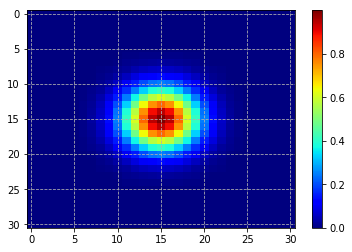

In [18]:
pylab.subplot(111)
im = pylab.imshow(np.abs(interp2d.reshape(bm_pix,bm_pix).T), aspect='auto', cmap='jet')
pylab.colorbar(im)
pylab.grid(ls='dashed')

In [9]:
# beamfile
beamfits = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')

# xx fitsfiles
fitsfile1_xx = os.path.join(DATA_PATH, '2458115.23736.xx.fits')
fitsfile2_xx = os.path.join(DATA_PATH, '2458115.24482.xx.fits')
fitsfiles_xx = [fitsfile1_xx, fitsfile2_xx]

# yy fitsfiles
fitsfile1_yy = os.path.join(DATA_PATH, '2458115.23736.yy.fits')
fitsfile2_yy = os.path.join(DATA_PATH, '2458115.24482.yy.fits')
fitsfiles_yy = [fitsfile1_yy, fitsfile2_yy]

# right ascension and declination values
ras = [30.01713089, 27.72922349, 36.75248962, 34.2415497, 78.3776346, 74.03785837]
decs = [-30.88211818, -29.53377208, -30.63958257, -29.93990039, -30.48595805, -30.08651873]

In [10]:
# generating catalog
catd = cd.catData()
catd.gen_catalog(fitsfiles_xx, ras, decs)

extract.py:148: Warning: WARNING: Right ascension or declination outside image field, therefore values are set to nan
  warnings.warn('WARNING: Right ascension or declination outside image field, therefore values are set to nan', Warning)


In [11]:
# simulating using a gaussian beam
catd_copy = copy.deepcopy(catd)
azalts = catd_copy.azalt_array
bm_pix = 31
bm_true = np.zeros((bm_pix, bm_pix), dtype=float)
bmx, bmy = np.indices(bm_true.shape)
mu = 15.; sigma=3.
bm_true = np.exp(-((bmx-mu)**2 + (bmy-mu)**2)/ (2 * sigma**2))
tx0, ty0, tz0 = get_top(bm_pix, center=(15, 15), res=0.5)
tx00, ty00, tz00 = tx0.flatten(), ty0.flatten(), tz0.flatten()
indices = np.arange(bm_pix**2)
azs, alts = aipy.coord.top2azalt([np.array(tx0[:,:]), np.array(ty0[:,:]), np.array(tz0[:,:])])
azs = np.rad2deg(azs); alts= np.rad2deg(alts)
_sh = azs.shape
#fluxvals = np.random.random(_sh[1]) + 10
newdata = np.zeros((1, _sh[0], _sh[1]))
for i in range(_sh[0]):
        tx, ty, tz = aipy.coord.azalt2top([np.deg2rad(azs[i, :]), np.deg2rad(alts[i, :])])
        tx_px = tx * 0.5*bm_pix + 0.5*bm_pix
        tx_px0 = np.floor(tx_px).astype(np.int)
        tx_px1 = np.clip(tx_px0+1,0,bm_pix-1)#tx_px0 + 1
        fx = tx_px - tx_px0
        ty_px = ty * 0.5*bm_pix + 0.5*bm_pix
        ty_px0 = np.floor(ty_px).astype(np.int)
        ty_px1 = np.clip(ty_px0+1,0,bm_pix-1)#ty_px0 + 1
        fy = ty_px - ty_px0
        x0y0 = np.array([tx_px0, ty_px0], dtype=np.int)
        x0y1 = np.array([tx_px0, ty_px1], dtype=np.int)
        x1y0 = np.array([tx_px1, ty_px0], dtype=np.int)
        x1y1 = np.array([tx_px1, ty_px1], dtype=np.int)
        w0 = ((1 - fx) * (1 - fy))**(-1)
        w1 = (fx * (1 - fy))**(-1)
        w2 = ((1 - fx) * fy)**(-1)
        w3 = (fx * fy)**(-1)
        for j in range(_sh[1]):
            weights = w0[j] + w1[j] + w2[j] + w3[j]
            A_s = (bm_true[tx_px0[j],ty_px0[j]] * w0[j] + bm_true[tx_px0[j],ty_px1[j]] * w1[j] + bm_true[tx_px1[j],ty_px0[j]] * w2[j] + bm_true[tx_px1[j], ty_px1[j]] * w3[j])/weights
            newdata[0, i, j] = peaks[i] * A_s
       
catd_copy.data_array = newdata.reshape((1, 31, 31))

catd_copy.azalt_array = np.zeros((2, _sh[0], _sh[1]))
catd_copy.azalt_array[0, :, :] = azs
catd_copy.azalt_array[1, :, :] = alts

In [12]:
print catd_copy.azalt_array.shape
print catd_copy.data_array.shape
print _sh

(2, 31, 31)
(1, 31, 31)
(31, 31)


In [13]:
print newdata[0, 0, :]
print catd_copy.data_array[0, 0, :]

[2.16747211e-05 5.51365587e-06 4.33129517e-06 4.47715769e-06
 3.71878181e-06 2.84848603e-05 1.72102647e-06 1.25903675e-05
 5.58744378e-06 2.26522856e-06 9.85613007e-06 6.03373378e-06
 1.24146533e-05 1.93498815e-05 2.67583708e-05 3.32124116e-05
 3.70012758e-05 3.70012786e-05 3.32124195e-05 2.67583801e-05
 1.95234726e-05 1.43755664e-05 2.23579692e-05 1.77278583e-05
 8.54131197e-06 1.95737584e-05 1.70668683e-05 1.90347097e-05
 1.99013618e-05 1.67320318e-05 1.91922369e-05]
[2.16747211e-05 5.51365587e-06 4.33129517e-06 4.47715769e-06
 3.71878181e-06 2.84848603e-05 1.72102647e-06 1.25903675e-05
 5.58744378e-06 2.26522856e-06 9.85613007e-06 6.03373378e-06
 1.24146533e-05 1.93498815e-05 2.67583708e-05 3.32124116e-05
 3.70012758e-05 3.70012786e-05 3.32124195e-05 2.67583801e-05
 1.95234726e-05 1.43755664e-05 2.23579692e-05 1.77278583e-05
 8.54131197e-06 1.95737584e-05 1.70668683e-05 1.90347097e-05
 1.99013618e-05 1.67320318e-05 1.91922369e-05]


In [16]:
print peaks

[10.00410126 10.67734367 10.41256063 10.71364469 10.30549137 10.10681978
 10.86161799 10.66051673 10.90133043 10.31409774 10.92734983 10.77354577
 10.76966346 10.92177178 10.07589569 10.55653715 10.63787599 10.85773372
 10.30611351 10.88256566 10.96512636 10.8367038  10.30754426 10.21629784
 10.0311886  10.470656   10.7813134  10.39985661 10.46789206 10.22709521
 10.23335079 10.86757695 10.88732154 10.34217065 10.63555745 10.01925685
 10.12925209 10.95674976 10.40168963 10.07484046]


In [32]:
catd_copy.azalt_array[0, 0, :]

array([314.99999966,  44.99999875,  43.02506662,  40.91438108,
        38.65980735,  36.25383906,  33.69006609,  30.96375851,
        28.0724848 ,  25.01689039,  21.80140808,  18.43495127,
        14.9314194 ,  11.30993016,   7.59464193,   3.81407758,
       359.9999975 , 356.18592424, 352.40535989, 348.69006483,
       345.06858242, 341.56505055, 338.19859374, 334.98311143,
       331.92751703, 329.03624331, 326.30993232, 323.74616617,
       321.34019106, 319.08561391, 316.9749352 ])

In [34]:
azs[0, :]

array([314.99999966,  44.99999875,  43.02506662,  40.91438108,
        38.65980735,  36.25383906,  33.69006609,  30.96375851,
        28.0724848 ,  25.01689039,  21.80140808,  18.43495127,
        14.9314194 ,  11.30993016,   7.59464193,   3.81407758,
       359.9999975 , 356.18592424, 352.40535989, 348.69006483,
       345.06858242, 341.56505055, 338.19859374, 334.98311143,
       331.92751703, 329.03624331, 326.30993232, 323.74616617,
       321.34019106, 319.08561391, 316.9749352 ])

In [44]:
def mk_key(px, i, t):
    return 'w%d_s%d_t%d' % (px, i, t)

def unravel_pix(n, i,j):
    return (i*n) + j
    

consts = OrderedDict()
eqs = OrderedDict()
interp2d = np.zeros((bm_pix**2))

time0 = time.time()
for i in range(_sh[0]):
    tx, ty, tz = aipy.coord.azalt2top([np.deg2rad(catd_copy.azalt_array[0,i,:]), np.deg2rad(catd_copy.azalt_array[1, i,:])])
    tx_px = tx * 0.5*bm_pix + 0.5*bm_pix
    tx_px0 = np.floor(tx_px).astype(np.int)
    tx_px1 = np.clip(tx_px0+1,0,bm_pix-1)#tx_px0 + 1
    fx = tx_px - tx_px0
    ty_px = ty * 0.5*bm_pix + 0.5*bm_pix
    ty_px0 = np.floor(ty_px).astype(np.int)
    ty_px1 = np.clip(ty_px0+1,0,bm_pix-1)#ty_px0 + 1
    fy = ty_px - ty_px0
    x0y0 = np.array([tx_px0, ty_px0], dtype=np.int)
    x0y1 = np.array([tx_px0, ty_px1], dtype=np.int)
    x1y0 = np.array([tx_px1, ty_px0], dtype=np.int)
    x1y1 = np.array([tx_px1, ty_px1], dtype=np.int)

    w0 = ((1 - fx) * (1 - fy))
    w1 = (fx * (1 - fy))
    w2 = ((1 - fx) * fy)
    w3 = (fx * fy)
    
    ps = [x0y0, x0y1, x1y0, x1y1]
    ws = [w0, w1, w2, w3]

    for j in range(_sh[1]):
        I_s = catd_copy.data_array[0, i, j]
        c = {mk_key(unravel_pix(bm_pix, ps[p][0,j], ps[p][1,j]), i, j): fluxvals[i] * ws[p][j] for p in xrange(len(ps))}
        eq = ' + '.join([mk_key(unravel_pix(bm_pix, ps[p][0,j], ps[p][1,j]), i, j) + \
             '*b%d'%(unravel_pix(bm_pix, ps[p][0,j], ps[p][1,j])) for p in xrange(len(ps))]) 
        eqs[eq] = I_s 
        consts.update(c)

eqs_noise = {k:v for k,v in eqs.items()}
ls = linsolve.LinearSolver(eqs_noise, **consts)
sol = ls.solve(verbose=True)

interp2d = np.zeros((bm_pix**2))
for key in sol.keys():
    px = int(key.strip('b'))     
    interp2d[px] = sol.get(key)
        
print 'Time Elapsed: {} s'.format(time.time() - time0)

Solving 0/1
Time Elapsed: 0.874167203903 s


In [63]:
keys = eqs.keys()
keys

['w150_s0_t0*b150 + w151_s0_t0*b151 + w181_s0_t0*b181 + w182_s0_t0*b182',
 'w832_s0_t1*b832 + w833_s0_t1*b833 + w863_s0_t1*b863 + w864_s0_t1*b864',
 'w832_s0_t2*b832 + w833_s0_t2*b833 + w863_s0_t2*b863 + w864_s0_t2*b864',
 'w802_s0_t3*b802 + w803_s0_t3*b803 + w833_s0_t3*b833 + w834_s0_t3*b834',
 'w802_s0_t4*b802 + w803_s0_t4*b803 + w833_s0_t4*b833 + w834_s0_t4*b834',
 'w771_s0_t5*b771 + w772_s0_t5*b772 + w802_s0_t5*b802 + w803_s0_t5*b803',
 'w772_s0_t6*b772 + w773_s0_t6*b773 + w803_s0_t6*b803 + w804_s0_t6*b804',
 'w741_s0_t7*b741 + w742_s0_t7*b742 + w772_s0_t7*b772 + w773_s0_t7*b773',
 'w711_s0_t8*b711 + w712_s0_t8*b712 + w742_s0_t8*b742 + w743_s0_t8*b743',
 'w711_s0_t9*b711 + w712_s0_t9*b712 + w742_s0_t9*b742 + w743_s0_t9*b743',
 'w680_s0_t10*b680 + w681_s0_t10*b681 + w711_s0_t10*b711 + w712_s0_t10*b712',
 'w650_s0_t11*b650 + w650_s0_t11*b650 + w681_s0_t11*b681 + w681_s0_t11*b681',
 'w619_s0_t12*b619 + w619_s0_t12*b619 + w650_s0_t12*b650 + w650_s0_t12*b650',
 'w588_s0_t13*b588 + w588_

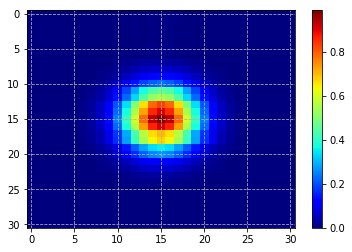

In [45]:
pylab.subplot(111)
im = pylab.imshow(np.abs(interp2d.reshape(bm_pix,bm_pix).T), aspect='auto', cmap='jet')
pylab.colorbar(im)
pylab.grid(ls='dashed')

In [55]:
catd_copy.data_array.shape

(1, 31, 31)

In [14]:
bms = bs.BeamSolve(catd_copy, bm_pix=31)

In [15]:
bmss = bms.beamsolver()

In [13]:
cstbeam1 = os.path.join(DATA_PATH, 'HERA_4.9m_E-pattern_152MHz.txt')
beam = bt.get_cstbeam(cstbeam1, [151e6], 151e6)

In [ ]:
corrfluxs = catd.calc_catalog_flux(beam, pol='xx')

In [16]:
bmss.construct_linear_sys(catalog_flux=peaks)

In [64]:
bmss.eqs
w494_s30_t16*b494 + w495_s30_t16*b495 + w525_s30_t16*b525 + w526_s30_t16*b526',

OrderedDict([('w494_s0_t0*b494 + w495_s0_t0*b495 + w525_s0_t0*b525 + w526_s0_t0*b526',
              2.1240247595061086e-06),
             ('w486_s0_t1*b486 + w487_s0_t1*b487 + w517_s0_t1*b517 + w518_s0_t1*b518',
              5.403133688518547e-07),
             ('w474_s1_t0*b474 + w475_s1_t0*b475 + w505_s1_t0*b505 + w506_s1_t0*b506',
              5.8991693575232875e-06),
             ('w466_s1_t1*b466 + w467_s1_t1*b467 + w497_s1_t1*b497 + w498_s1_t1*b498',
              2.124024732957804e-06),
             ('w475_s2_t0*b475 + w476_s2_t0*b476 + w506_s2_t0*b506 + w507_s2_t0*b507',
              4.80426659467409e-06),
             ('w466_s2_t1*b466 + w467_s2_t1*b467 + w497_s2_t1*b497 + w498_s2_t1*b498',
              1.8807527722197805e-06),
             ('w475_s3_t0*b475 + w476_s3_t0*b476 + w506_s3_t0*b506 + w507_s3_t0*b507',
              4.87526301025422e-06),
             ('w466_s3_t1*b466 + w467_s3_t1*b467 + w497_s3_t1*b497 + w498_s3_t1*b498',
              1.6396642128413643e-06)

In [20]:
sol = bmss.ls.solve(verbose=True)
sol

Solving 0/1


{'b100': 3.6638345854266e-07,
 'b128': 4.844574412620755e-06,
 'b129': 7.541590608192872e-06,
 'b130': 3.665869958691854e-05,
 'b131': 1.8362971799332945e-07,
 'b150': 2.08398421029277e-06,
 'b151': 2.444888503125507e-06,
 'b159': 4.4030964624719e-06,
 'b160': 6.540649846913903e-06,
 'b181': 1.7763541765593948e-06,
 'b182': 2.083983113835079e-06,
 'b810': 2.2984474428535892e-06,
 'b811': 1.8755045621799436e-06,
 'b832': 6.219352847361884e-07,
 'b833': 5.301271288136573e-07,
 'b841': 2.4708799771572547e-06,
 'b842': 1.7545123705152542e-06,
 'b843': 6.187005915832907e-07,
 'b844': 2.2385791042242715e-06,
 'b863': 5.30128151208193e-07,
 'b864': 4.5187227932003196e-07,
 'b873': 1.7301776854780762e-06,
 'b874': 2.4214130025278355e-06,
 'b875': 1.1219601221285652e-06,
 'b98': -0.00011820666281037848,
 'b99': 2.0829153622404877e-05}

In [18]:
obsbeam = bmss.eval_sol(sol)

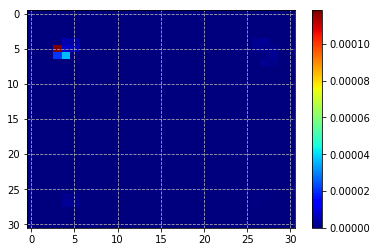

In [19]:
pylab.subplot(111)
im = pylab.imshow(np.abs(obsbeam.T), aspect='auto', cmap='jet')
pylab.colorbar(im)
pylab.grid(ls='dashed')

In [21]:
# beamfile
beamfits = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')

# xx fitsfiles
fitsfile1_xx = os.path.join(DATA_PATH, '2458115.23736.xx.fits')
fitsfile2_xx = os.path.join(DATA_PATH, '2458115.24482.xx.fits')
fitsfiles_xx = [fitsfile1_xx, fitsfile2_xx]

# yy fitsfiles
fitsfile1_yy = os.path.join(DATA_PATH, '2458115.23736.yy.fits')
fitsfile2_yy = os.path.join(DATA_PATH, '2458115.24482.yy.fits')
fitsfiles_yy = [fitsfile1_yy, fitsfile2_yy]

# right ascension and declination values
ras = [30.01713089, 27.72922349, 36.75248962, 34.2415497, 78.3776346, 74.03785837]
decs = [-30.88211818, -29.53377208, -30.63958257, -29.93990039, -30.48595805, -30.08651873]

In [29]:
import catdata as cd
srcd = cd.catData()
srcd.read_hdf5('srcd_xx.h5')
#srcd.gen_catalog(fitsfiles_xx, ras, decs)

In [23]:
cstbeam1 = os.path.join(DATA_PATH, 'HERA_4.9m_E-pattern_152MHz.txt')
beam = bt.get_cstbeam(cstbeam1, [151e6], 151e6)

In [37]:
corrfluxs = srcd.calc_catalog_flux(beam, pol='xx')

In [38]:
print srcd.data_array.shape
print corrfluxs.shape

(1, 120, 42)
(120,)


# Beam Rotation

In [57]:
catd_xx = cd.catData()
catd_xx.read_hdf5('srcd_xx.h5')

catd_yy = cd.catData()
catd_yy.read_hdf5('srcd_yy.h5')

beamfits = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')
beam_xx = bt.get_fitsbeam(beamfits, 151e6, 'xx')
beam_yy = bt.get_fitsbeam(beamfits, 151e6, 'yy')
catalog_flux_xx = catd_xx.calc_catalog_flux(beam_xx, 'xx')
catalog_flux_yy = catd_yy.calc_catalog_flux(beam_yy, 'xx')
print catalog_flux_xx.shape

azalts = catd_xx.azalt_array
_sh = azalts.shape

Casting complex values to real discards the imaginary part


(120,)


In [58]:
catd_copy = copy.deepcopy(catd_xx)
poldata = np.zeros((2, _sh[1], _sh[2]))
poldata[0, :, :] = catd_xx.data_array
poldata[1, :, :] = catd_yy.data_array
catd_copy.data_array = poldata
catd_copy.Npols = 2

In [61]:
%load_ext autoreload
%autoreload
bms_xx = bs.BeamSolve(catd_copy)
bmss_xx = bms_xx.beamsolver(cross=True)
bmss_xx.construct_linear_sys(catalog_flux_xx=catalog_flux_xx, catalog_flux_yy=catalog_flux_yy, theta_xx=[0], theta_yy=[np.pi/2])
sol_xx = bmss_xx.ls.solve(verbose=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Solving 0/1


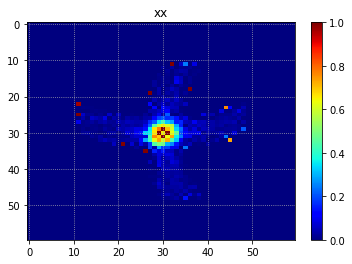

In [63]:
obsbeam_xx = bmss_xx.eval_sol(sol_xx)
pylab.subplot(111)
pylab.title('xx')
pylab.imshow(obsbeam_xx.T, aspect='auto', cmap='jet', vmin=0, vmax=1.0)
pylab.colorbar()
pylab.grid(ls='dotted')

In [54]:
def mk_key(px, i, t):
    return 'w%d_I%d_t%d' % (px, i, t)

def unravel_pix(n, i,j):
    return (i*n) + j

consts = OrderedDict()
eqs = OrderedDict()

time0 = time.time()
sol_dict = {}

for i in range(_sh[1]):
    tx, ty, tz = aipy.coord.azalt2top([np.deg2rad(azalts[0, i,:]), np.deg2rad(azalts[1, i,:])])
    tx_px = tx * 0.5*bm_pix + 0.5*bm_pix
    tx_px0 = np.floor(tx_px).astype(np.int)
    tx_px1 = np.clip(tx_px0+1,0,bm_pix-1)#tx_px0 + 1
    fx = tx_px - tx_px0
    ty_px = ty * 0.5*bm_pix + 0.5*bm_pix
    ty_px0 = np.floor(ty_px).astype(np.int)
    ty_px1 = np.clip(ty_px0+1,0,bm_pix-1)#ty_px0 + 1
    fy = ty_px - ty_px0
    x0y0 = np.array([tx_px0, ty_px0], dtype=np.int)
    x0y1 = np.array([tx_px0, ty_px1], dtype=np.int)
    x1y0 = np.array([tx_px1, ty_px0], dtype=np.int)
    x1y1 = np.array([tx_px1, ty_px1], dtype=np.int)

    w0 = ((1 - fx) * (1 - fy))
    w1 = (fx * (1 - fy))
    w2 = ((1 - fx) * fy)
    w3 = (fx * fy)
    
    # rotating by 90 degrees
    origin = (int(bm_pix/2), int(bm_pix/2))
    theta = np.pi/2
    
    rx0y0 = np.array([ty_px0,  tx_px0], dtype=np.int)
    rx0y1 = np.array([ty_px1,  tx_px0], dtype=np.int)
    rx1y0 = np.array([ty_px0,  tx_px1], dtype=np.int)
    rx1y1 = np.array([ty_px1,  tx_px1], dtype=np.int)
    
    ps = [x0y0, x0y1, x1y0, x1y1]
    rps = [rx0y0, rx0y1, rx1y0, rx1y1]
    ws = [w0, w1, w2, w3]
    
 
    sol_dict['I%d'%i] = 1.0#hera_corrfluxs[i]
    for j in range(_sh[2]):
        weights = w0[j] + w1[j] + w2[j] + w3[j]
        A_s1 = (bm_true[tx_px0[j],ty_px0[j]] * w0[j] + bm_true[tx_px0[j],ty_px1[j]] * w1[j] + \
          bm_true[tx_px1[j],ty_px0[j]] * w2[j] + bm_true[tx_px1[j], ty_px1[j]] * w3[j])
        I_s1 = A_s1 * hera_corrfluxs[i]
        
        c1 = {mk_key(unravel_pix(bm_pix, ps[p][0,j], ps[p][1,j]), i, j): ws[p][j] for p in xrange(len(ps))}
        eq = ' + '.join([mk_key(unravel_pix(bm_pix, ps[p][0,j], ps[p][1,j]), i, j) + \
             '*b%d'%(unravel_pix(bm_pix, ps[p][0,j], ps[p][1,j])) + '*I%d'%i for p in xrange(len(ps))]) 
        eqs[eq] = I_s1
        consts.update(c1)
                      

        A_s2 = (bm_true[rps[0][0,j], rps[0][1,j]] * w0[j] + bm_true[rps[1][0,j], rps[1][1,j]] * w1[j] + \
           bm_true[rps[2][0,j], rps[2][1,j]] * w2[j] + bm_true[rps[3][0,j], rps[3][1,j]] * w3[j])
        
        I_s2 = A_s2 * hera_corrfluxs[i]
        c2 = {mk_key(unravel_pix(bm_pix, rps[p][0,j], rps[p][1,j]), i, j): ws[p][j] for p in xrange(len(rps))}
        eq = ' + '.join([mk_key(unravel_pix(bm_pix, rps[p][0,j], rps[p][1,j]), i, j) + \
             '*b%d'%(unravel_pix(bm_pix, rps[p][0,j], rps[p][1,j])) + '*I%d'%i for p in xrange(len(rps))]) 
        eqs[eq] = I_s2
        consts.update(c2)
        
        for p in xrange(len(ps)):
            sol_dict['b%d'%(unravel_pix(bm_pix, ps[p][0,j], ps[p][1,j]))] = 1.0
            sol_dict['b%d'%(unravel_pix(bm_pix, rps[p][0,j], rps[p][1,j]))] = 1.0

eqs['b%d'%(unravel_pix(bm_pix, int(bm_pix/2.), int(bm_pix/2.)))] = 1.0 #constraint
#sol_dict['b%d'%(unravel_pix(bm_pix, int(bm_pix/2.), int(bm_pix/2.)))] = 1.0
eqs_noise = {k:v for k,v in eqs.items()}
ls = linsolve.LinProductSolver(eqs_noise, sol0=sol_dict, **consts)#
sol = ls.solve_iteratively(verbose=True)

print 'Time Elapsed: {} s'.format(time.time() - time0)

Beginning iteration 1/50
Solving 0/1
Beginning iteration 2/50
Solving 0/1
Beginning iteration 3/50
Solving 0/1
Beginning iteration 4/50
Solving 0/1
Beginning iteration 5/50
Solving 0/1
Beginning iteration 6/50
Solving 0/1
Time Elapsed: 37.9495019913 s


In [55]:
xinterp2d_xx = np.zeros((bm_pix**2))
ids = []
srcfluxs = []
for key in sol[1].keys():
    if key[0]=='b':
        px = int(key.strip('b'))
        xinterp2d_xx[px] = sol[1].get(key)
        
    if key[0] == 'I':
        n = int(key.strip('I'))
        ids.append(n)
        srcfluxs.append(sol[1].get(key))

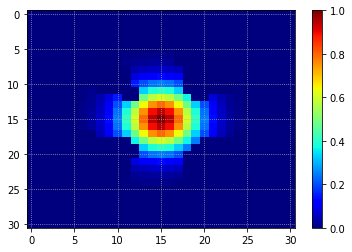

In [56]:
pylab.imshow(xinterp2d_xx.reshape(31, 31).T, aspect='auto', cmap='jet', vmin=0)
pylab.colorbar()
pylab.grid(ls='dotted')

In [77]:
def mk_key(px, i, t):
    return 'w%d_I%d_t%d' % (px, i, t)

def unravel_pix(n, i,j):
    return (i*n) + j

consts = OrderedDict()
eqs = OrderedDict()

time0 = time.time()
sol_dict = {}

for i in range(0, 5):
    tx, ty, tz = aipy.coord.azalt2top([np.deg2rad(azalts[0, i,:]), np.deg2rad(azalts[1, i,:])])
    tx_px = tx * 0.5*bm_pix + 0.5*bm_pix
    tx_px0 = np.floor(tx_px).astype(np.int)
    tx_px1 = np.clip(tx_px0+1,0,bm_pix-1)#tx_px0 + 1
    fx = tx_px - tx_px0
    ty_px = ty * 0.5*bm_pix + 0.5*bm_pix
    ty_px0 = np.floor(ty_px).astype(np.int)
    ty_px1 = np.clip(ty_px0+1,0,bm_pix-1)#ty_px0 + 1
    fy = ty_px - ty_px0
    x0y0 = np.array([tx_px0, ty_px0], dtype=np.int)
    x0y1 = np.array([tx_px0, ty_px1], dtype=np.int)
    x1y0 = np.array([tx_px1, ty_px0], dtype=np.int)
    x1y1 = np.array([tx_px1, ty_px1], dtype=np.int)

    w0 = ((1 - fx) * (1 - fy))
    w1 = (fx * (1 - fy))
    w2 = ((1 - fx) * fy)
    w3 = (fx * fy)
    
    # rotating by 90 degrees
    origin = (int(bm_pix/2), int(bm_pix/2))
    theta = np.pi/2
    
    rx0y0 = np.array([ty_px0,  tx_px0], dtype=np.int)
    rx0y1 = np.array([ty_px1,  tx_px0], dtype=np.int)
    rx1y0 = np.array([ty_px0,  tx_px1], dtype=np.int)
    rx1y1 = np.array([ty_px1,  tx_px1], dtype=np.int)
    
    
    print x0y0[:,0], rx0y0[:, 0]
    #print x0y1[:,0], rx0y1[:, 0]
    #print x1y0[:,0], rx1y0[:, 0]
    #print x1y1[:,0], rx1y1[:, 0]

[16 15] [15 16]
[16 15] [15 16]
[15 16] [16 15]
[15 14] [14 15]
[15 13] [13 15]


In [103]:
def get_weights(azalts, theta=0, flip=1):
        """
        Returns the four closest pixels to the azimuth-altitude values on the 2D
        grid.

        Parameters
        ----------
        azalts : ndarray
            2D array consisting of the azimuth and alitutes values in degrees.
        """

        # selecting the four closest pixels
        bm_pix = 31
        tx, ty, tz = aipy.coord.azalt2top([azalts[0, :] * np.pi/180., azalts[1, :] * np.pi/180.])
        #tx, ty = np.dot(rotate_mat(theta), np.array([tx, ty]))
        #tx = flip * tx
        tx_px = tx * 0.5 * bm_pix + 0.5 * bm_pix
        ty_px = ty * 0.5 * bm_pix + 0.5 * bm_pix
        tx_px0 = np.floor(tx_px).astype(np.int)
        tx_px1 = np.clip(tx_px0 + 1, 0, bm_pix -1)
        ty_px0 = np.floor(ty_px).astype(np.int)
        ty_px1 = np.clip(ty_px0 + 1, 0, bm_pix -1)

        x0y0 = np.array([tx_px0, ty_px0], dtype=np.int)
        x0y1 = np.array([tx_px0, ty_px1], dtype=np.int)
        x1y0 = np.array([tx_px1, ty_px0], dtype=np.int)
        x1y1 = np.array([tx_px1, ty_px1], dtype=np.int)

        x0y0 = np.dot(rotate_mat(theta), x0y0)
        x0y1 = np.dot(rotate_mat(theta), x0y1)
        x1y0 = np.dot(rotate_mat(theta), x1y0)
        x1y1 = np.dot(rotate_mat(theta), x1y1)
        
        x0y0[0] = flip * x0y0[0]
        x0y1[0] = flip * x0y1[0]
        x1y0[0] = flip * x1y0[0]
        x1y1[0] = flip * x1y1[0]
        
        cpix = int(bm_pix / 2.)
        for k in range(len(x0y0[0])):
            if x0y0[0][k] < 0 : x0y0[0][k] = cpix - np.abs(x0y0[0][k])
            if x0y1[0][k] < 0 : x0y1[0][k] = cpix - np.abs(x0y1[0][k])
            if x1y0[0][k] < 0 : x1y0[0][k] = cpix - np.abs(x1y0[0][k])
            if x1y1[0][k] < 0 : x1y1[0][k] =  cpix - np.abs(x1y1[0][k])
                       
        # defining the weights
        print 'azalt:', azalts[:,0]
        print tx[0], ty[0]
        print tx_px[0], ty_px[0]
        print x0y0[:, 0]
        print '********'
        #print x0y1[:, 0]
        #print x1y0[:, 0]
        #print x1y1[:, 0]
    
def _mk_key(pixel, srcid, timeid):
        """
        Generates key to represent the beam pixel which include the source id,
        timestamp and pixel.

        Parameters
        ----------
        pixel : int
            Pixel from the 2D grid beam.

        srcid : int
            Source identity.

        timeid : int
            Time identity or timestamps.

        Returns
        -------
            String corresponding the given parameters.
        """

        return 'w%d_s%d_t%d' % (pixel, srcid, timeid)
    
def unravel_pix(ndim, coord):
        """
        Returns the unraveled/flattened pixel of any (m, n) position
        or coordinates on any square 2D-grid

        Parameters
        ----------
        coord : tuple of int
            Coordinates (m, n) for which to calculate the  flattened index.

        Returns
        -------
        index of the flattened array corresponding to the coordinates (m, n).
        """

        return (coord[0] * ndim) + coord[1]
    
def rotate_mat(theta):
        """
        Rotate coordinates or pixels by theta degrees

        Parameters
        ----------
        theta : float
            Angle by which the coordinates or pixels will be rotated.
        """

        return np.array([[np.cos(theta), -1*np.sin(theta)], [np.sin(theta), np.cos(theta)]])

for i in range(4, 5):
    get_weights(azalts[:, i, :], 0, 1)
    get_weights(azalts[:, i, :], np.pi/2, -1)
    get_weights(azalts[:, i, :], np.pi/2, 1)
    

azalt: [186.76293048  84.29025123]
-0.011715981324929695 -0.09879680101028009
15.31840228946359 13.968649584340659
[15. 13.]
********
azalt: [186.76293048  84.29025123]
-0.011715981324929695 -0.09879680101028009
15.31840228946359 13.968649584340659
[13. 15.]
********
azalt: [186.76293048  84.29025123]
-0.011715981324929695 -0.09879680101028009
15.31840228946359 13.968649584340659
[ 2. 15.]
********


In [84]:
rot = rotate_mat(np.pi/2)
print np.dot(rot, np.array([15, 13]))

[-13.  15.]


In [100]:
a = np.array([3,4,5,6])

In [101]:
30-a

array([27, 26, 25, 24])